## Sequence Modelling with Recurrent Neural Networks - Tweet sentiment classification with RNNs

Here we are going to explore
- Recurrent Neural Networks (RNNs) fundamentals
- Understanding Long-Short Term Memory Networks (LSTMs) (they are an improvemnt to original RNN)
- Better Tweet sentiment classification with RNNs
- Build a cryptocurrency price prediction Bot with RNNs

- What RNNs are ?
- How do RNNs work ?
- Why are RNNs suited for sequence tasks ?

<img src="resources/recurrentunit.png" alt="recurrentunit" width="70%" height="70%" border="1" />

**N-Grams Vs RNNs**

**N-Grams**
- Limited to context of N
- Representations note shared - struggles from sparsity
- Cannot handle long-term dependencies

**RNNs**
- Near-limitless context
- Shared representation powerful to overcome sparsity
- Capable of handling long-term dependencies

**LSTMs**
- Problems with RNNs - THe Vanishing Gradient problem (Information decay over time)
- Undestanding LSTM equations & motivations
- Why are LSTMs better than plain RNNs

<img src="resources/lstmunit.png" alt="lstmunit" width="70%" height="70%" border="1" />
<img src="resources/lstmunitgates1.png" alt="lstmunitgates" width="70%" height="70%" border="1" />

Here we will
- Clean & tokenize text into sequences
- Build LSTM networks
- Classify tweet sentiment with LSTM networks

In [2]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sklearn.feature_extraction.text
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
from sklearn import preprocessing
import re
import string
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

plt.ioff()
pd.set_option('display.max_columns', None)

Using TensorFlow backend.


## Download data from [here](https://www.kaggle.com/crowdflower/twitter-airline-sentiment)

In [3]:
data_frame = pd.read_csv('data/Tweets.csv')

In [4]:
print("{} Tweets in dataset".format(len(data_frame)))
data_frame.head()

14640 Tweets in dataset


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
tweets_text = data_frame['text']
tweets_sentiment = data_frame['airline_sentiment']

In [6]:
print("Tweet: {}".format(tweets_text[18]))
print("Sentiment: {}".format(tweets_sentiment[18]))

print ""
print("Tweet: {}".format(tweets_text[17]))
print("Sentiment: {}".format(tweets_sentiment[17]))

Tweet: I ❤️ flying @VirginAmerica. ☺️👍
Sentiment: positive

Tweet: @VirginAmerica  I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!
Sentiment: negative


In [7]:
print("Tweet: {}".format(tweets_text[3]))
print("Sentiment: {}".format(tweets_sentiment[3]))

Tweet: @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
Sentiment: negative


In [9]:
from keras.preprocessing.text import Tokenizer
docs = tweets_text
vocab_size = 5000
t = Tokenizer(num_words=vocab_size)
t.fit_on_texts(docs)
sequences = t.texts_to_sequences(docs)
print(sequences[0])

[81, 62, 226]


In [10]:
# pading all tweets to length 20 i.e. if more than 20 it will be truncated else remaining 0 will be added in front
print(sequences[10])
max_review_length = 20
X = sequence.pad_sequences(sequences, maxlen=max_review_length)
print(X[10,...])
y_mapping = {'negative':[1, 0, 0], 'neutral':[0, 1, 0], 'positive':[0, 0, 1]}
y_list = [y_mapping[sentiment.lower()] for sentiment in tweets_sentiment]
y = np.array(y_list)

[81, 122, 6, 112, 27, 2537, 14, 2, 618, 2115, 785, 18, 1484, 1760, 2538, 211, 425]
[   0    0    0   81  122    6  112   27 2537   14    2  618 2115  785   18
 1484 1760 2538  211  425]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4., random_state=1)
print(X_train.shape)
print(y_train.shape)

(10980, 20)
(10980, 3)


In [12]:
print(y_train.shape)

(10980, 3)


In [13]:
print(X_train[0:])

[[  44  104  101 ...,    2  157  382]
 [   2 2402  957 ...,  336  481  146]
 [   0    0    0 ...,   10  168  533]
 ..., 
 [   0    0    0 ...,   39   47  180]
 [  81 1060  325 ...,  409    1 1011]
 [ 224    7  104 ...,    8  175  408]]


In [15]:
embedding_vecor_length = 64
model = Sequential()
model.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=5, batch_size=64,  validation_data=(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 64)            320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 128)           98816     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 468,419
Trainable params: 468,419
Non-trainable params: 0
_________________________________________________________________
None
Train on 10980 samples, validate on 3660 samples
Epoch 1/5
10980/10980 [==============================] - 197s 18ms/step - loss: 0.7169 - acc: 0.6976 - val_loss: 0.5753 - val_acc: 0.7626
Epoch 2/5
10980/10980 [==============================] - 192s 17ms/step - lo

In [16]:
# Final evaluation of the model
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_pred_class = np.argmax(y_train_pred, axis=1)
y_test_pred_class = np.argmax(y_test_pred, axis=1)
y_train_class = np.argmax(y_train, axis=1)
y_test_class = np.argmax(y_test, axis=1)

train_accuracy = sklearn.metrics.accuracy_score(y_train_class, y_train_pred_class)
test_accuracy = sklearn.metrics.accuracy_score(y_test_class, y_test_pred_class)
print("Train Accuracy {}%".format(train_accuracy*100.0))
print("Test Accuracy {}%".format(test_accuracy*100))

cf_matrix = confusion_matrix(y_test_class, y_test_pred_class)
print("Confusion Matrix")
print(cf_matrix)

Train Accuracy 94.5810564663%
Test Accuracy 77.8142076503%
Confusion Matrix
[[1958  215  118]
 [ 217  448  109]
 [  93   60  442]]


Normalized confusion matrix
[[ 0.85464863  0.09384548  0.05150589]
 [ 0.28036176  0.57881137  0.14082687]
 [ 0.15630252  0.10084034  0.74285714]]


<IPython.core.display.Javascript object>


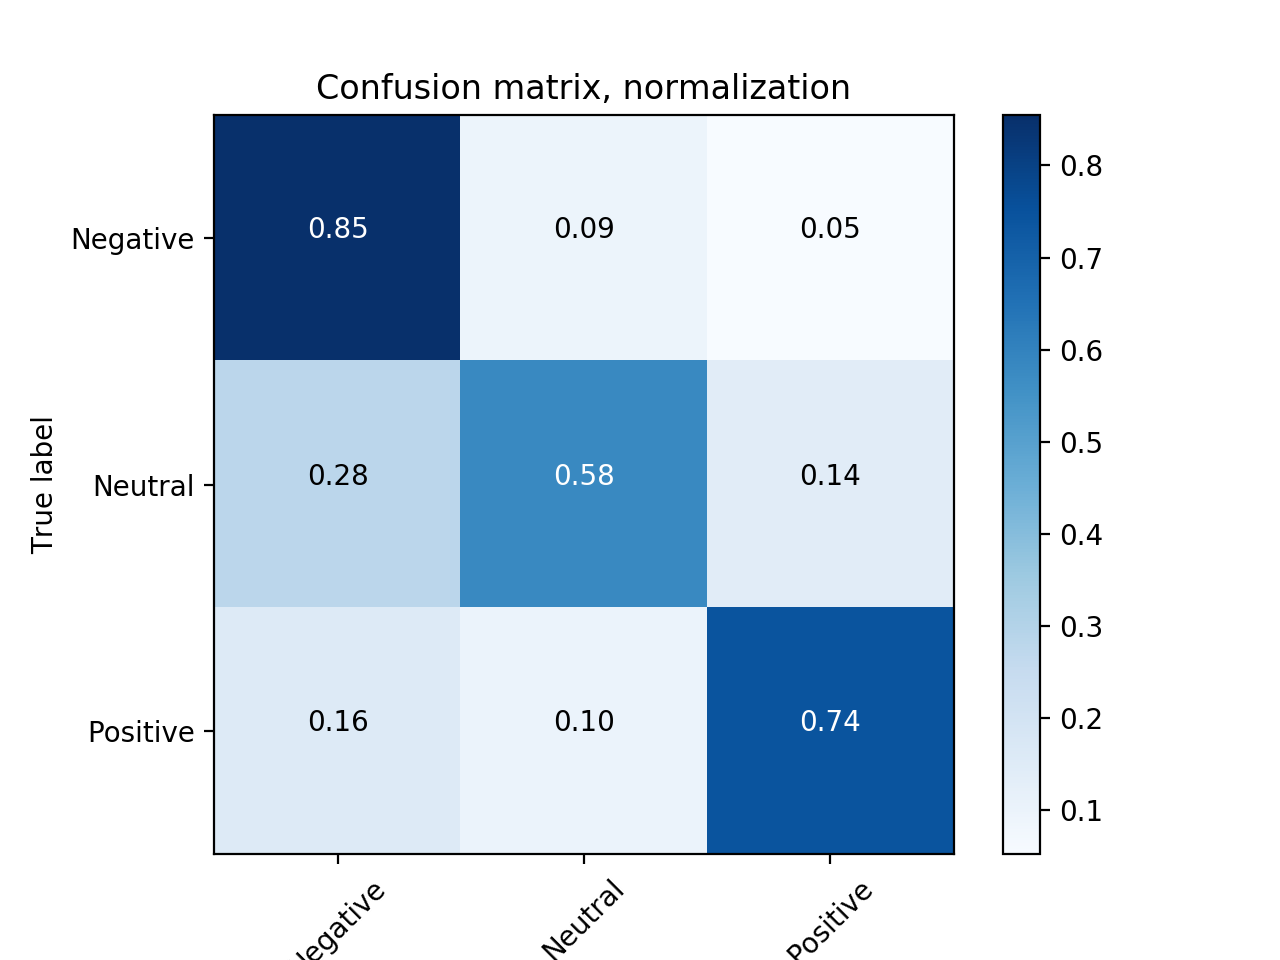

In [17]:
# adapted from:
# https://github.com/scikit-learn/scikit-learn/blob/master/examples/model_selection/plot_confusion_matrix.py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
plot_confusion_matrix(cf_matrix, classes=["Negative", "Neutral", "Positive"],
                      title='Confusion matrix, normalization', normalize=True)
plt.show()